In [1]:
import os
import re
import time
import spacy
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
import pandas as pd
from models import Gen
import warnings as wrn
import logging
from tqdm import tqdm

SEED = 2021

wrn.filterwarnings('ignore')
os.environ['SP_DIR'] = '/opt/conda/lib/python3.11/site-packages'
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cuda.deterministic = True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# MODE = 'inference' # 'train' or 'inference' or 'none'

### Load Data

In [4]:
train_data = pd.read_csv('data/ag_news/train.csv', header=None, usecols=[0,2])
train_data.columns = ['label', 'text']
valid_data = pd.read_csv('data/ag_news/valid.csv', header=None, usecols=[0,2])
valid_data.columns = ['label', 'text']
test_data = pd.read_csv('data/ag_news/test.csv', header=None, usecols=[0,2])
test_data.columns = ['label', 'text']

In [5]:
TRAIN_SIZE = len(train_data)
VALID_SIZE = len(valid_data)
TEST_SIZE = len(test_data)
print(TRAIN_SIZE, VALID_SIZE, TEST_SIZE)

120000 5000 7600


### Clean Data

In [6]:
# def clean_text(text):
#     return re.sub(r'[^A-Za-z0-9]+', ' ', str(text))

In [7]:
# train_data['text'] = train_data['text'].apply(clean_text)
# valid_data['text'] = valid_data['text'].apply(clean_text)
# test_data['text'] = test_data['text'].apply(clean_text)

# train_data.to_csv('data/ag_news3/train_clean.csv', index=False, header=False)
# valid_data.to_csv('data/ag_news3/valid_clean.csv', index=False, header=False)
# test_data.to_csv('data/ag_news3/test_clean.csv', index=False, header=False)

### Tokenize Data

In [8]:
spacy_en = spacy.load('en_core_web_sm')

def spacy_tokenizer(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [9]:
LABEL = data.LabelField()
TEXT = data.Field(tokenize=spacy_tokenizer, batch_first=True, include_lengths=True)
fields = [('label', LABEL), ('text', TEXT)]

In [10]:
train_dataset = data.TabularDataset(path='data/ag_news/train_clean.csv', format='csv', fields=fields, skip_header=True)
valid_dataset = data.TabularDataset(path='data/ag_news/valid_clean.csv', format='csv', fields=fields, skip_header=True)
test_dataset = data.TabularDataset(path='data/ag_news/test_clean.csv', format='csv', fields=fields, skip_header=True)

In [11]:
print(vars(train_dataset.examples[0]))

{'label': '4', 'text': ['Apple', 'yesterday', 'released', 'a', '12', '7', 'MB', 'security', 'update', 'that', 'consists', 'of', 'several', 'revised', 'components', 'including', 'Apache', 'AppKit', 'HIToolbox', 'Kerberos', 'Postfix', 'PSNormalizer', 'Safari', 'and', 'Terminal']}


In [12]:
TEXT.build_vocab(train_dataset, min_freq=5)
LABEL.build_vocab(train_dataset)

In [13]:
import random
from collections import defaultdict
from torchtext import data

def sample_uneven_by_class(dataset, label_field, global_fraction, class_distribution, seed=2021):
    """
    Samples a subset from `dataset` with an *uneven* class distribution.

    Args:
        dataset: TorchText Dataset (e.g., train_dataset).
                 Important: This dataset must share the same label_field
                 whose vocabulary is *already built* so that
                 label_field.vocab.stoi[...] works correctly.
        label_field: The corresponding LabelField object (e.g., LABEL).
                     Must have label_field.vocab built already.
        global_fraction: The fraction of the entire dataset to sample (e.g. 0.1).
        class_distribution: List of fractions specifying how the total sample
                            should be divided among classes. Must sum to 1.0.
                            Example: [0.30, 0.25, 0.25, 0.20] for 4 classes.
        seed: For reproducible sampling.
    
    Returns:
        A new TorchText Dataset with the uneven distribution among classes.
    """
    random.seed(seed)
    
    total_size = len(dataset)
    total_sample_size = int(total_size * global_fraction)
    
    # Group examples by *numeric label index*
    label_to_examples = defaultdict(list)
    for ex in dataset.examples:
        # Typically ex.label is a *string*, so convert to numeric index
        label_str = ex.label
        numeric_idx = label_field.vocab.stoi[label_str]
        label_to_examples[numeric_idx].append(ex)
    
    # number of classes based on your specified distribution
    num_classes = len(class_distribution)

    # Alternatively, you could infer the number of distinct labels from the dataset:
    # num_classes_in_data = len(label_to_examples.keys())

    # Check for mismatch
    if num_classes != len(label_to_examples):
        raise ValueError(
            f"Mismatch in # of classes: distribution has {num_classes} entries, "
            f"but data has {len(label_to_examples)} distinct labels."
        )
    
    # Compute how many examples from each class we *want* to sample
    samples_per_class = []
    for i in range(num_classes):
        desired_count = int(class_distribution[i] * total_sample_size)
        samples_per_class.append(desired_count)
    
    # Because of integer rounding, sum might not match total_sample_size
    sum_samples = sum(samples_per_class)
    diff = total_sample_size - sum_samples
    
    # Distribute leftover or shortage due to rounding
    idx = 0
    while diff > 0:
        samples_per_class[idx] += 1
        diff -= 1
        idx = (idx + 1) % num_classes
    while diff < 0:
        if samples_per_class[idx] > 0:
            samples_per_class[idx] -= 1
            diff += 1
        idx = (idx + 1) % num_classes
    
    # Now sample from each class
    sampled_examples = []
    for class_idx in range(num_classes):
        examples_list = label_to_examples[class_idx]
        to_sample = min(samples_per_class[class_idx], len(examples_list))
        
        # random.sample raises an error if to_sample > len(examples_list), hence min(...)
        sampled = random.sample(examples_list, to_sample)
        sampled_examples.extend(sampled)
    
    # Build a new TorchText Dataset from the sampled examples
    new_dataset = data.Dataset(
        sampled_examples,
        fields={
            "label": label_field,
            "text": dataset.fields["text"],  # or rename if your text field is different
        }
    )
    
    return new_dataset

In [14]:
global_fraction = 0.05
class_distribution = [0.25, 0.25, 0.25, 0.25]

ActCheckData= sample_uneven_by_class(
    dataset=test_dataset,
    label_field=LABEL,
    global_fraction=global_fraction,
    class_distribution=class_distribution,
    seed=2021
)

TEST_SIZE = len(ActCheckData)

In [15]:
from collections import Counter

def show_class_distribution(dataset, label_field):
    label_counts = Counter(ex.label for ex in dataset.examples)
    for label_str, count in label_counts.items():
        numeric_idx = label_field.vocab.stoi[label_str]
        print(f"Class '{label_str}' -> index {numeric_idx} -> {count} examples")

show_class_distribution(ActCheckData, LABEL)

Class '2' -> index 0 -> 95 examples
Class '3' -> index 1 -> 95 examples
Class '4' -> index 2 -> 95 examples
Class '1' -> index 3 -> 94 examples


In [16]:
label_counts = {LABEL.vocab.itos[i]: LABEL.vocab.freqs[LABEL.vocab.itos[i]] for i in range(len(LABEL.vocab))}
print("Number of instances per class:", label_counts)

print("Size of text vocab:",len(TEXT.vocab))

print("Size of label vocab:",len(LABEL.vocab))

Number of instances per class: {'2': 30000, '3': 30000, '4': 30000, '1': 29999}
Size of text vocab: 27797
Size of label vocab: 4


In [17]:
TEXT.vocab.freqs.most_common(10)

[('the', 174008),
 ('to', 96378),
 ('a', 95595),
 ('of', 89434),
 ('in', 76339),
 ('and', 66138),
 ('on', 47406),
 ('s', 43763),
 ('for', 37311),
 ('39', 31877)]

In [18]:
BATCH_SIZE = 32

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

test_iterator = data.BucketIterator(
    test_dataset,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

ActCheckIterator = data.BucketIterator(
    ActCheckData,
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

### Define Batches

In [19]:
VOCAB_SIZE= len(TEXT.vocab)
WORD_EMB_DIM = 100
LABEL_EMB_DIM = 100
HID_DIM = 100
NLAYERS = 1
NCLASS = len(LABEL.vocab)
DROPOUT = 0
USE_CUDA = torch.cuda.is_available()
TIED = False
USE_BIAS = False
CONCAT_LABEL = 'hidden'
AVG_LOSS = False
ONE_HOT = False
BIT_WIDTH = 4

LR = 1e-4
LOG_INTERVAL = 200
CLIP = 1.0
LOGGING = logging.INFO

In [20]:
model = Gen(VOCAB_SIZE, WORD_EMB_DIM, LABEL_EMB_DIM, HID_DIM, NLAYERS, NCLASS, DROPOUT, USE_CUDA, TIED, USE_BIAS, CONCAT_LABEL, AVG_LOSS, ONE_HOT).to(device)
criterion = nn.CrossEntropyLoss(reduce=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [21]:
def init_hidden(model, bsz):
    weight = next(model.parameters())
    # Return hidden state and cell state as 2D tensors
    return (weight.new_zeros(NLAYERS, HID_DIM),
            weight.new_zeros(NLAYERS, HID_DIM))

In [22]:
def evaluate(valid_iterator, model, criterion, mode='valid', model_state=0):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    cnt = 0
    
    with torch.no_grad():
        for batch in tqdm(valid_iterator, desc=f"Evaluating ({mode})", leave=True):
            sents = [torch.tensor(row) for row in batch.text[0]]
            labels = batch.label
            # y_exts = [torch.full((batch.text[0].shape[1],), labels[i], dtype=torch.long) for i in range(len(labels))]
            y_exts = []
            for y_label in range(NCLASS):
                y_ext = []
                for d in sents:
                    y_ext.append(torch.LongTensor([y_label] * (len(d) - 1)))
                y_exts.append(y_ext)
            
            
            hidden = init_hidden(model, len(sents))
            x = nn.utils.rnn.pack_sequence([s[:-1] for s in sents])
            x_pred = nn.utils.rnn.pack_sequence([s[1:] for s in sents])

            # p_y = torch.FloatTensor([0.071] * len(seq_len))

            losses = []
            for y_ext in y_exts:
                y_ext = nn.utils.rnn.pack_sequence(y_ext)

                if device.type == 'cuda':
                    x, y_ext, x_pred, labels = x.cuda(), y_ext.cuda(), x_pred.cuda(), labels.cuda()

                # output (batch_size, )
                hidden = init_hidden(model, len(sents))
                
                out = model(x, x_pred, y_ext, hidden, criterion, model_state)
                
                loss_matrix = criterion(out, x_pred.data)

                LM_loss = nn.utils.rnn.pad_packed_sequence(nn.utils.rnn.PackedSequence(
                    loss_matrix, x.batch_sizes))[0].transpose(0,1)
                sum_loss = torch.sum(LM_loss, dim = 1)
                
                losses.append(sum_loss)

            losses = torch.cat(losses, dim=0).view(-1, len(sents))
            prediction = torch.argmin(losses, dim=0)

            num_correct = (prediction == labels).float().sum()

            total_loss += torch.sum(torch.min(losses, dim=0)[0]).item()
            total_correct += num_correct.item()
            cnt += 1

    return total_loss / cnt, total_correct / (VALID_SIZE if mode == 'valid' else TEST_SIZE if mode == 'test' else '0') * 100.0

In [23]:
activation_histograms = {}

def activation_hook(name):
    def hook(model, input, output):
        # If the output is a tuple (e.g., LSTM), take the first element
        if isinstance(output, tuple):
            output = output[0]  # Extract the actual output tensor
        activation_histograms[name] = output.detach().cpu().numpy()
    return hook

In [24]:
# Register hooks for layers you want to track
model.encoder.register_forward_hook(activation_hook('encoder'))
model.label_encoder.register_forward_hook(activation_hook('label_encoder'))
model.rnn.register_forward_hook(activation_hook('rnn'))
model.decoder.register_forward_hook(activation_hook('decoder'))

In [25]:
model.load_state_dict(torch.load('gen_lstm_spacy_ag_news.pth'))
model.eval()

test_loss, test_acc = evaluate(ActCheckIterator, model, criterion, mode='test', model_state='fp')
print('=' * 89)
print(f'Test Loss: {test_loss} | Test Acc:  {test_acc}')
print('=' * 89)

Evaluating (test): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.82it/s]

Test Loss: 7420.6780192057295 | Test Acc:  87.59894459102902


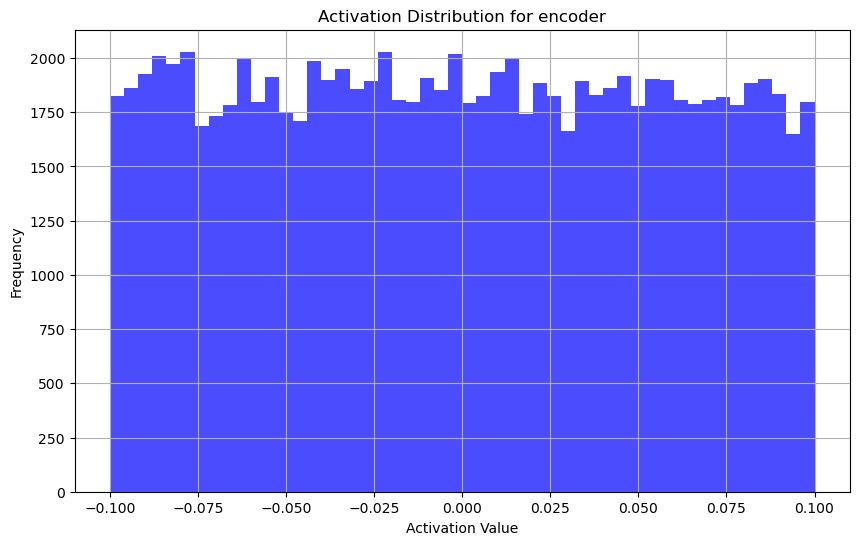

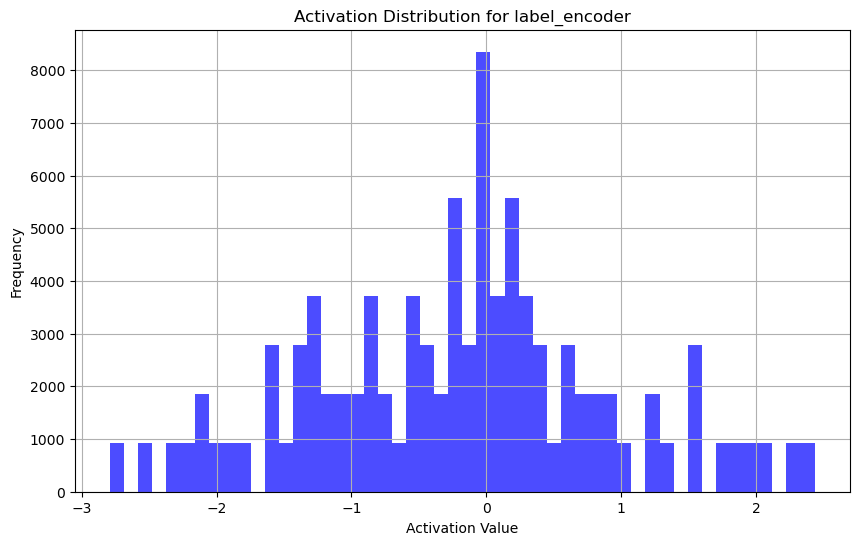

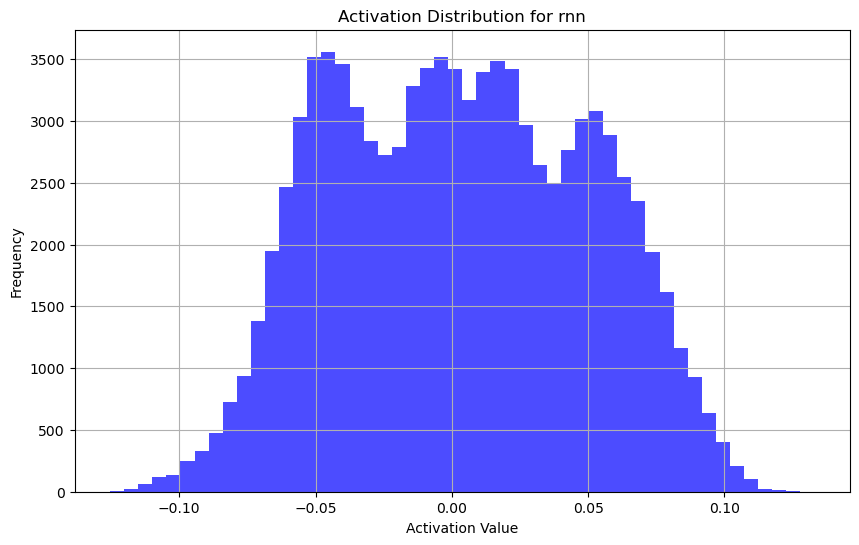

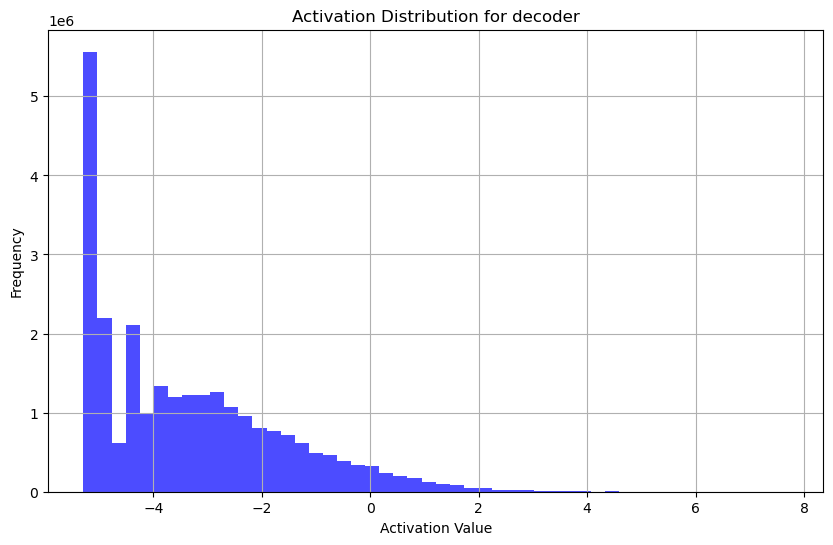

In [26]:
import matplotlib.pyplot as plt

def plot_activation_histograms(activation_histograms):
    for layer_name, activations in activation_histograms.items():
        # Flatten the activations for histogram plotting
        flattened_activations = activations.flatten()
        plt.figure(figsize=(10, 6))
        plt.hist(flattened_activations, bins=50, alpha=0.7, color='blue')
        plt.title(f'Activation Distribution for {layer_name}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

# Now each layer in `activation_histograms` is a list of NumPy arrays
import numpy as np

for layer_name in activation_histograms:
    all_batches = activation_histograms[layer_name]
    # Concatenate across batch dimension
    activation_histograms[layer_name] = np.concatenate(all_batches, axis=0)

plot_activation_histograms(activation_histograms)

In [27]:
def save_activation_histograms(activation_histograms, folder="activation_histograms"):
    os.makedirs(folder, exist_ok=True)  # Create directory if it doesn't exist

    for layer_name, activations in activation_histograms.items():
        flattened_activations = activations.flatten()

        # Save the histogram as an image
        plt.figure(figsize=(10, 6))
        plt.hist(flattened_activations, bins=50, alpha=0.7, color='blue')
        plt.title(f'Activation Distribution for {layer_name}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.grid(True)

        file_path = os.path.join(folder, f"{layer_name}_histogram.png")
        plt.savefig(file_path)
        plt.close()  # Close figure to free memory

        print(f"Saved histogram image: {file_path}")

# Call this function after running a forward pass
save_activation_histograms(activation_histograms)

Saved histogram image: activation_histograms/encoder_histogram.png
Saved histogram image: activation_histograms/label_encoder_histogram.png
Saved histogram image: activation_histograms/rnn_histogram.png
Saved histogram image: activation_histograms/decoder_histogram.png


In [28]:
import pandas as pd

def save_activation_data_csv(activation_histograms, folder="activation_data_csv"):
    os.makedirs(folder, exist_ok=True)

    for layer_name, activations in activation_histograms.items():
        flattened_activations = activations.flatten()

        # Convert to DataFrame and save as CSV
        df = pd.DataFrame(flattened_activations, columns=["Activation"])
        file_path = os.path.join(folder, f"{layer_name}_activations.csv")
        df.to_csv(file_path, index=False)
        print(f"Saved activations as .csv: {file_path}")

# Call this function to save activations as CSV
save_activation_data_csv(activation_histograms)

Saved activations as .csv: activation_data_csv/encoder_activations.csv
Saved activations as .csv: activation_data_csv/label_encoder_activations.csv
Saved activations as .csv: activation_data_csv/rnn_activations.csv
Saved activations as .csv: activation_data_csv/decoder_activations.csv


In [29]:
def save_activation_data_npy(activation_histograms, folder="activation_data_npy"):
    os.makedirs(folder, exist_ok=True)

    for layer_name, activations in activation_histograms.items():
        file_path = os.path.join(folder, f"{layer_name}_activations.npy")
        np.save(file_path, activations)
        print(f"Saved activations as .npy: {file_path}")

# Call this function to save activations
save_activation_data_npy(activation_histograms)

Saved activations as .npy: activation_data_npy/encoder_activations.npy
Saved activations as .npy: activation_data_npy/label_encoder_activations.npy
Saved activations as .npy: activation_data_npy/rnn_activations.npy
Saved activations as .npy: activation_data_npy/decoder_activations.npy


In [30]:
from brevitas.graph.quantize import preprocess_for_quantize
from ptq_common import quantize_model, apply_bias_correction, apply_act_equalization

In [31]:
# pre_model = preprocess_for_quantize(
#             model,
#             equalize_iters=20,
#             equalize_merge_bias=True,
#             merge_bn=True,
#             channel_splitting_ratio=0.0,
#             channel_splitting_split_input=False)

In [32]:
dtype = getattr(torch, 'float')
device = torch.device('cpu')
print("device is set to ",device)
print("Quantizing the model")
quant_model = quantize_model(
        model.to(device),
        dtype=dtype,
        device=device,
        backend='layerwise',
        scale_factor_type='float_scale',
        bias_bit_width=32,
        weight_bit_width=BIT_WIDTH,
        weight_narrow_range=False,
        weight_param_method='stats',
        weight_quant_granularity='per_tensor',
        weight_quant_type='sym',
        layerwise_first_last_bit_width=BIT_WIDTH,
        act_bit_width=BIT_WIDTH,
        act_param_method='stats',
        act_quant_percentile=99.99,
        act_quant_type='sym',
        quant_format='int',
        layerwise_first_last_mantissa_bit_width=4,
        layerwise_first_last_exponent_bit_width=3,
        weight_mantissa_bit_width=4,
        weight_exponent_bit_width=3,
        act_mantissa_bit_width=4,
        act_exponent_bit_width=3).to(device) 

print("Quantization completed!")
device = torch.device('cuda')
print("device is set back to ",device)
model=model.to(device)
quant_model=quant_model.to(device)

device is set to  cpu
Quantizing the model
Quantization completed!
device is set back to  cuda


In [33]:
quant_model.load_state_dict(torch.load(f'./GenQuantResultsWithUnevenDist_ag_news/ModelParameter_Gen_{BIT_WIDTH}bit_0.25_0.25_0.25_0.25.pth', map_location=device), strict=False)
quant_model=quant_model.to(device)

In [34]:
for name, param in quant_model.named_parameters():
    print(name)

encoder.weight
encoder.weight_quant.tensor_quant.scaling_impl.value
label_encoder.weight
label_encoder.weight_quant.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.output_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.cell_state_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.input_acc_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.forget_acc_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.cell_acc_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.output_acc_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.input_sigmoid_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.forget_sigmoid_quant.fused_activation_quant_proxy.tensor_quant.scaling_impl.value
rnn.layers.0.0.cell.cell_tanh_quant.fused_activation_quant_proxy.ten

In [35]:
activation_histograms_quant = {}

def activation_hook(layer_name):
    """
    Creates a hook function that:
      1) Extracts the output tensor.
      2) Appends it to a dictionary entry keyed by `layer_name`.
    """
    def hook(module, inp, out):
        # Some modules (LSTM) may output tuples (e.g., (output, (h_n, c_n))).
        # We only want the actual output tensor, so if it's a tuple, pick out [0].
        if isinstance(out, tuple):
            out = out[0]
        # Convert to CPU numpy for easy accumulation
        out_np = out.detach().cpu().numpy()

        # Accumulate batch by batch
        if layer_name not in activation_histograms_quant:
            activation_histograms_quant[layer_name] = []
        activation_histograms_quant[layer_name].append(out_np)
    return hook

In [36]:
# Clear dictionary in case we re-run multiple times
activation_histograms_quant.clear()

quant_model.encoder.register_forward_hook(activation_hook("encoder"))
quant_model.label_encoder.register_forward_hook(activation_hook("label_encoder"))
quant_model.rnn.register_forward_hook(activation_hook("rnn"))
quant_model.decoder.register_forward_hook(activation_hook("decoder"))

In [ ]:
test_loss, test_acc = evaluate(ActCheckIterator, quant_model, criterion, mode='test', model_state='quant')
print('=' * 89)
print(f'Test Loss: {test_loss} | Test Acc before calibration:  {test_acc}')
print('=' * 89)

Evaluating (test):  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 11/12 [03:59<00:20, 20.37s/it]

In [ ]:
for layer_name, acts_list in activation_histograms_quant.items():
    # Merge all batches along the first dimension
    # If these are shape [batch_size, ...], 
    # you'll get a big array with shape [num_samples, ...].
    acts = np.concatenate(acts_list, axis=0)

    # Flatten for histogram
    flattened_acts = acts.flatten()

    plt.figure(figsize=(8, 5))
    plt.hist(flattened_acts, bins=50, alpha=0.7, color='blue')
    plt.title(f'Quant Model Activation Distribution: {layer_name}')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# def plot_activation_histograms(activation_histograms):
#     for layer_name, activations in activation_histograms.items():
#         # Flatten the activations for histogram plotting
#         flattened_activations = activations.flatten()
#         plt.figure(figsize=(10, 6))
#         plt.hist(flattened_activations, bins=50, alpha=0.7, color='blue')
#         plt.title(f'Activation Distribution for {layer_name}')
#         plt.xlabel('Activation Value')
#         plt.ylabel('Frequency')
#         plt.grid(True)
#         plt.show()

# # Call this function to visualize histograms
# plot_activation_histograms(activation_histograms)

In [ ]:
def save_activation_histograms(activation_histograms_quant, folder="activation_histograms_quant"):
    os.makedirs(folder, exist_ok=True)  # Create directory if it doesn't exist

    for layer_name, acts_list in activation_histograms_quant.items():
        acts = np.concatenate(acts_list, axis=0)

        # Flatten for histogram
        flattened_activations = acts.flatten()

        # Save the histogram as an image
        plt.figure(figsize=(10, 6))
        plt.hist(flattened_activations, bins=50, alpha=0.7, color='blue')
        plt.title(f'Activation Distribution for {layer_name}')
        plt.xlabel('Activation Value')
        plt.ylabel('Frequency')
        plt.grid(True)

        file_path = os.path.join(folder, f"{layer_name}_histogram.png")
        plt.savefig(file_path)
        plt.close()  # Close figure to free memory

        print(f"Saved histogram image: {file_path}")

# Call this function after running a forward pass
save_activation_histograms(activation_histograms_quant)